In [ ]:
## John's CNN for Chest X-rays

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/MyDrive/chest_xray.zip

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as tfk
import sklearn
import numpy as np
np.random.seed(10)
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pathlib
import PIL
import glob as gb
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
### Code by John Bower is only the CNN model, noted in comments above code section. 

### Following code credit to: Haasha Bin Atif
# Research Assistant at CBRLab, FAST-NUCES
# Islamabad, Islamabad Capital Territory, Pakistan
# http://cbrlab.org/index.html
### Following code from: https://www.kaggle.com/code/haashaatif/day-4-deep-learning-in-medical
### Code used for loading and preprocesing data. 

In [ ]:
#Function which can create csv's for the given dataset
def create_csv(base_path,csv_name):
    paths = ["NORMAL","PNEUMONIA"]
    with open(csv_name,'w') as file:
        file.write(",".join(["path","class"])+"\n")
        for idx,path in enumerate(paths):
            temp = np.array(os.listdir(os.path.join(base_path,path)))
            for image in temp:
                file.write(",".join([os.path.join(base_path,path,image),str(idx)])+"\n")
                
create_csv("/content/chest_xray/train","train.csv")
create_csv("/content/chest_xray/val","val.csv")
create_csv("/content/chest_xray/test","test.csv")

In [ ]:
train_df = pd.read_csv("./train.csv")
train_x, train_y = np.array(train_df["path"].values.tolist()),np.array(train_df["class"].values.tolist())


val_df = pd.read_csv("./val.csv")
val_x, val_y = np.array(val_df["path"].values.tolist()),np.array(val_df["class"].values.tolist())

test_df = pd.read_csv("./test.csv")
test_x, test_y = np.array(test_df["path"].values.tolist()),np.array(test_df["class"].values.tolist())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c4afc3990>]],
      dtype=object)

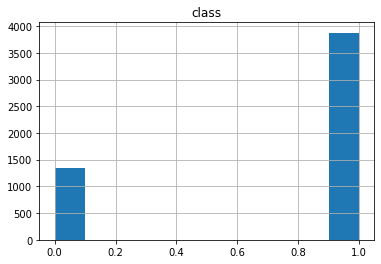

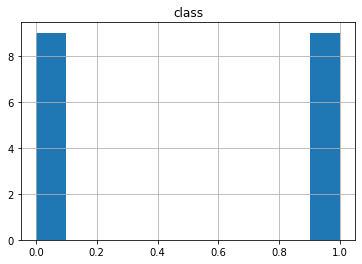

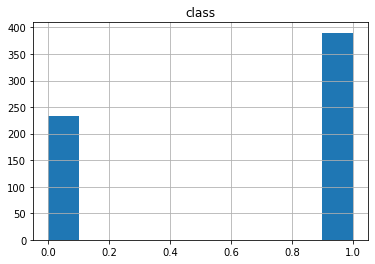

In [ ]:
train_df.hist()
val_df.hist()
test_df.hist()

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [ ]:
## Image size changed by John Bower
IMAGE_SIZE = 128
##

In [ ]:
train = image_generator.flow_from_directory("/content/chest_xray/train", 
                                            batch_size=16, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 5216 images belonging to 2 classes.


In [ ]:
validation = image_generator.flow_from_directory("/content/chest_xray/val", 
                                                batch_size=2, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 16 images belonging to 2 classes.


In [ ]:
test = image_generator.flow_from_directory("/content/chest_xray/test", 
                                            batch_size=16, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 624 images belonging to 2 classes.


In [ ]:
class XRayGenerator(tf.keras.utils.Sequence):
    def __init__(self,X,Y,batch_size=10,shuffle=True,transform=None,return_labels = True):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.return_labels = return_labels
        self.length = len(Y)
        self.indices = np.arange(0,self.length)
        self.on_epoch_end()

    def generateBatches(self):
        self.X_ = self.X[self.indices]
        self.Y_ = self.Y[self.indices]
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.generateBatches()
    
    def __get_input(self, path):
        image = tfk.preprocessing.image.load_img(path)
        image_arr = tfk.preprocessing.image.img_to_array(image)
        if self.transform:
            image_arr = self.transform(image_arr)
        return image_arr
    
    def __get_output(self, label, num_classes):
        
        return tfk.utils.to_categorical(label, num_classes=num_classes)

    def __getitem__(self,index):
        paths_x = self.X_[index*self.batch_size:(index+1)*self.batch_size]
        images = np.asarray([self.__get_input(image_path) for image_path in paths_x])
        #labels = self.__get_output(self.Y_[index*self.batch_size:(index+1)*self.batch_size],2)
        labels = self.Y_[index*self.batch_size:(index+1)*self.batch_size]
        if self.return_labels:
            return images,labels
        return images

    def __len__(self):
        return self.length//self.batch_size

In [ ]:
IMAGE_SIZE = 128
train_transform = tf.keras.Sequential([
                                        tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                        tf.keras.layers.RandomFlip("horizontal"),
                                        tf.keras.layers.RandomContrast(factor=(0.0,0.1)),
                                        tf.keras.layers.Rescaling(1./255),
                                ])
test_transform = tf.keras.Sequential([
                                        tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                        tf.keras.layers.Rescaling(1./255),
                                ])
train_loader = XRayGenerator(train_x,train_y,batch_size=8,shuffle=True,transform=train_transform,return_labels = True)
val_loader = XRayGenerator(val_x,val_y,batch_size=2,shuffle=True,transform=test_transform, return_labels = True)
test_loader = XRayGenerator(test_x,test_y,batch_size=8,shuffle=False,transform=test_transform, return_labels = True)

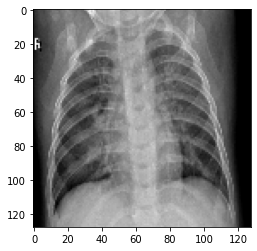

In [ ]:
batch = next(iter(train_loader))
plt.imshow(batch[0][1])

In [ ]:
### My Code begins below here!!!!
# CNN Model designed by John Bower

In [ ]:
model = tfk.models.Sequential()
model.add(tfk.layers.Conv2D(16, (3,3), strides=1, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(tfk.layers.BatchNormalization())
model.add(tfk.layers.MaxPool2D((2,2), strides=1, padding='same'))
model.add(tfk.layers.Conv2D(32,(3,3), strides =1, padding='same'))
model.add(tfk.layers.Dropout(0.6))
model.add(tfk.layers.BatchNormalization())
model.add(tfk.layers.MaxPool2D((2,2), strides=1, padding='same'))
model.add(tf.keras.layers.Flatten(input_shape=[IMAGE_SIZE,IMAGE_SIZE]))
model.add(tf.keras.layers.Dense(units = 10, activation="relu"))
model.add(tf.keras.layers.Dense(units=5, activation="relu"))
model.add(tf.keras.layers.Dense(units=2, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_28 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 dropout_10 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_29 (Bat  (None, 128, 128, 32)   

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train, batch_size=40, epochs=30, validation_data=validation)

Epoch 1/30
326/326 [==============================] - 71s 192ms/step - loss: 0.9267 - accuracy: 0.7212 - val_loss: 0.7194 - val_accuracy: 0.5000
Epoch 2/30
326/326 [==============================] - 62s 191ms/step - loss: 0.5903 - accuracy: 0.7429 - val_loss: 0.7638 - val_accuracy: 0.5000
Epoch 3/30
326/326 [==============================] - 62s 191ms/step - loss: 0.5744 - accuracy: 0.7429 - val_loss: 0.7982 - val_accuracy: 0.5000
Epoch 4/30
326/326 [==============================] - 62s 190ms/step - loss: 0.5708 - accuracy: 0.7429 - val_loss: 0.8163 - val_accuracy: 0.5000
Epoch 5/30
326/326 [==============================] - 62s 190ms/step - loss: 0.5702 - accuracy: 0.7429 - val_loss: 0.8225 - val_accuracy: 0.5000
Epoch 6/30
326/326 [==============================] - 62s 191ms/step - loss: 0.5701 - accuracy: 0.7429 - val_loss: 0.8271 - val_accuracy: 0.5000
Epoch 7/30
326/326 [==============================] - 63s 192ms/step - loss: 0.5701 - accuracy: 0.7429 - val_loss: 0.8266 - val_ac